In [1]:
!pip install transformers
!pip install xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 910.8 kB/s eta 0:00:00


In [2]:
!nvidia-smi

Wed Nov  9 13:36:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import xlrd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import AutoModel, AutoConfig, AutoTokenizer, BertModel, BertConfig, BertTokenizer, RobertaModel, RobertaConfig, RobertaTokenizer,AdamW, get_cosine_schedule_with_warmup

transformers.utils.logging.set_verbosity_error()

class Bert(nn.Module):
    def __init__(self, bert_path, classes=2):
        super(Bert, self).__init__()
        self.config = BertConfig.from_pretrained(bert_path)
        self.bert = BertModel.from_pretrained(bert_path)
        self.fc = nn.Linear(self.config.hidden_size, classes)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        out = outputs[1]
        out = self.fc(out)
        return out
    
class Roberta(nn.Module):
    def __init__(self, roberta_path, classes=2):
        super(Roberta, self).__init__()
        self.config = RobertaConfig.from_pretrained(roberta_path)
        self.roberta = RobertaModel.from_pretrained(roberta_path)
        self.fc = nn.Linear(self.config.hidden_size, classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.roberta(input_ids, attention_mask)
        out = outputs[1]
        out = self.fc(out)
        return out

class Covid_Twitter_Bert(nn.Module):
    def __init__(self, covid_twitter_bert_path, classes=2):
        super(Covid_Twitter_Bert, self).__init__()
        self.config = AutoConfig.from_pretrained(covid_twitter_bert_path)
        self.covidtwitterbert = AutoModel.from_pretrained(covid_twitter_bert_path)
        self.fc = nn.Linear(self.config.hidden_size, classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.covidtwitterbert(input_ids, attention_mask)
        out = outputs[1]
        out = self.fc(out)
        return out
    
class Covid_Sci_Bert(nn.Module):
    def __init__(self, covid_sci_bert_path, classes=2):
        super(Covid_Sci_Bert, self).__init__()
        self.config = AutoConfig.from_pretrained(covid_sci_bert_path)
        self.covidscibert = AutoModel.from_pretrained(covid_sci_bert_path)
        self.fc = nn.Linear(self.config.hidden_size, classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.covidscibert(input_ids, attention_mask)
        out = outputs[1]
        out = self.fc(out)
        return out

def evaluate(model_path, weight, data_loader, device):
    correct = 0
    total = 0
    ground = []
    for idx, (ids, att, y) in enumerate(data_loader["Bert"]):
        ground.append(y.detach().cpu().numpy())
    ground = np.concatenate(ground,axis=0)
    
    total = ground.shape[0]
    pred_sum = np.zeros_like(ground)
        
    with torch.no_grad():
        for key, path in model_path.items():
            pred = []
            model = eval(key)
            model = model(path).to(DEVICE)
            model.load_state_dict(torch.load("checkpoint/best_{}_model.pth".format(key.lower())))
            model.eval()

            for idx, (ids, att, y) in tqdm(enumerate(data_loader[key]), total=len(data_loader[key])):
                out = model(ids.to(device), att.to(device))
                pred.append((weight[key] * F.softmax(out, dim=-1)).cpu().numpy())
            
            pred = np.concatenate(pred,axis=0)
            pred_sum = pred_sum+pred
            
            del model
            
    pred_sum = np.argmax(pred_sum,axis=-1)
    ground = np.argmax(ground,axis=-1)
    correct = np.sum(pred_sum==ground)
    
    return correct/total, ground, pred_sum

In [4]:
model_path = {"Bert":"bert-base-uncased", "Roberta": "roberta-base",
             "Covid_Sci_Bert":"lordtt13/COVID-SciBERT",
             "Covid_Twitter_Bert":"digitalepidemiologylab/covid-twitter-bert-v2"}
model_Tokenizer = {"Bert": BertTokenizer.from_pretrained(model_path["Bert"]), 
                   "Roberta": RobertaTokenizer.from_pretrained(model_path["Roberta"]),
                    "Covid_Sci_Bert": AutoTokenizer.from_pretrained(model_path["Covid_Sci_Bert"]),
                    "Covid_Twitter_Bert": AutoTokenizer.from_pretrained(model_path["Covid_Twitter_Bert"])}

path = "data/english_test_with_labels.xls"
dataset = {"Bert": None, "Roberta": None,"Covid_Sci_Bert":None,"Covid_Twitter_Bert":None}

for key, value in dataset.items():
    input_ids = []
    attention_mask = []
    label = []

    excel = xlrd.open_workbook(path)
    sheet = excel.sheet_by_index(0)
    column_rows = sheet.nrows
    
    tokenizer = model_Tokenizer[key]
    
    for row in range(1, column_rows):
        data = sheet.row_values(row)
        encode_dict = (tokenizer.encode_plus(
            data[1], max_length=140, padding='max_length', truncation=True))

        input_ids.append(encode_dict['input_ids'])
        attention_mask.append(encode_dict['attention_mask'])

        if data[2] == "real":
            label.append([0,1])
        else:
            label.append([1,0])

    input_ids = torch.LongTensor(input_ids)
    attention_mask = torch.LongTensor(attention_mask)
    label = torch.LongTensor(label)

    dataset[key] = [input_ids, attention_mask, label]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
BATCH_SIZE = 32

test_data = {}
test_loader = {}

for key, value in dataset.items():
    test_data[key] = TensorDataset(dataset[key][0],
                                  dataset[key][1],
                                  dataset[key][2])
    test_loader[key] = DataLoader(
            test_data[key], shuffle=False, batch_size=BATCH_SIZE)

In [6]:
weight = {'Bert': 0.9738, 'Roberta':0.9794, "Covid_Sci_Bert":0.9785,"Covid_Twitter_Bert":0.9864}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc, ground, pred = evaluate(model_path, weight, test_loader, DEVICE)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

100%|██████████| 67/67 [00:09<00:00,  7.10it/s]


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

100%|██████████| 67/67 [00:08<00:00,  7.82it/s]


Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

100%|██████████| 67/67 [00:08<00:00,  7.83it/s]


Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

100%|██████████| 67/67 [00:29<00:00,  2.30it/s]


In [7]:
print(float(acc))

0.985981308411215


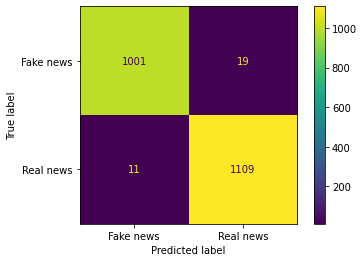

<Figure size 432x288 with 0 Axes>

In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(ground, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Fake news", "Real news"])
cm_display.plot()
plt.figure(facecolor='white')
plt.show()

In [9]:
print("F1 score is {}".format(metrics.f1_score(ground, pred, average='weighted')))
print("acc score is {}".format(metrics.accuracy_score(ground, pred)))

F1 score is 0.9859786568527138
acc score is 0.985981308411215


In [10]:
model_path = {"Bert":"bert-base-uncased"}
acc, ground, pred = evaluate(model_path, weight, test_loader, DEVICE)
print("F1 score is {}".format(metrics.f1_score(ground, pred, average='weighted')))
print("acc score is {}".format(metrics.accuracy_score(ground, pred)))

100%|██████████| 67/67 [00:08<00:00,  7.85it/s]

F1 score is 0.9798989515242079
acc score is 0.9799065420560747


In [11]:
model_path = {"Roberta": "roberta-base"}
acc, ground, pred = evaluate(model_path, weight, test_loader, DEVICE)
print("F1 score is {}".format(metrics.f1_score(ground, pred, average='weighted')))
print("acc score is {}".format(metrics.accuracy_score(ground, pred)))

100%|██████████| 67/67 [00:08<00:00,  7.83it/s]

F1 score is 0.978025158093107
acc score is 0.97803738317757


In [12]:
model_path = {"Covid_Sci_Bert":"lordtt13/COVID-SciBERT"}
acc, ground, pred = evaluate(model_path, weight, test_loader, DEVICE)
print("F1 score is {}".format(metrics.f1_score(ground, pred, average='weighted')))
print("acc score is {}".format(metrics.accuracy_score(ground, pred)))

100%|██████████| 67/67 [00:08<00:00,  7.87it/s]

F1 score is 0.9775658509643422
acc score is 0.9775700934579439


In [13]:
model_path = {"Covid_Twitter_Bert":"digitalepidemiologylab/covid-twitter-bert-v2"}
acc, ground, pred = evaluate(model_path, weight, test_loader, DEVICE)
print("F1 score is {}".format(metrics.f1_score(ground, pred, average='weighted')))
print("acc score is {}".format(metrics.accuracy_score(ground, pred)))

100%|██████████| 67/67 [00:29<00:00,  2.30it/s]

F1 score is 0.98551433251549
acc score is 0.9855140186915888


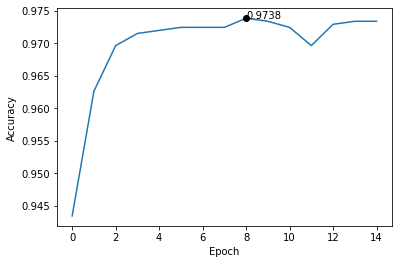

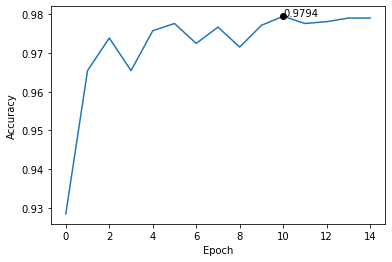

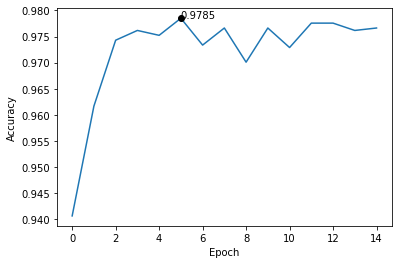

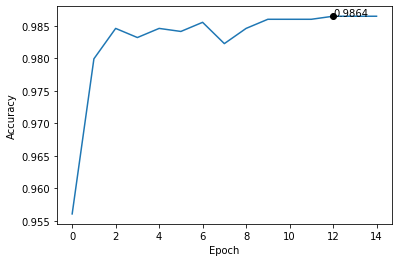

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os

models = ["Bert", "Roberta", "CovidSciBert", "CovidTwitterBert"]

acc = {}
for model in models:
    acc[model] = np.load(os.path.join(model, "accuracy.npy"))
    x = range(acc[model].shape[0])

    plt.figure()
    plt.plot(x, acc[model])
    plt.plot(np.argmax(acc[model]), np.max(acc[model]), 'ko')
    show = format(float(np.max(acc[model])), ".4f")
    plt.annotate(show, xy=(np.argmax(acc[model]), np.max(
        acc[model])), xytext=(np.argmax(acc[model]), np.max(acc[model])))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
